# Getting started with AudioSeal

This notebook shows a minimal example to get started with AudioSeal. Make sure you install the package from PyPi or from source in editable mode beforehand.

** NOTE**: In some PyTorch version, running the notebook might cause hanging issues. If that is the case, try turn off torch dynamo (set NO_TORCH_COMPILE=1 before running Jupyter)

First, let's prepare some example audios into the proper Tensor format using Torchaudio

In [1]:
%%capture

# For the demonstration, we need some libraries to process example audios and visualize the spectrogram
import sys
!{sys.executable} -m pip install torchaudio soundfile matplotlib julius

In [2]:
import torch
import torchaudio
import urllib

def download_sample_audio():
    url = "https://keithito.com/LJ-Speech-Dataset/LJ037-0171.wav"
    with open("test.wav", "wb") as f:
        resp = urllib.request.urlopen(url)
        f.write(resp.read())
    
    wav, sample_rate = torchaudio.load("test.wav")
    return wav, sample_rate

audio, sr = download_sample_audio()

(Quick check of the original content and spectrogram)

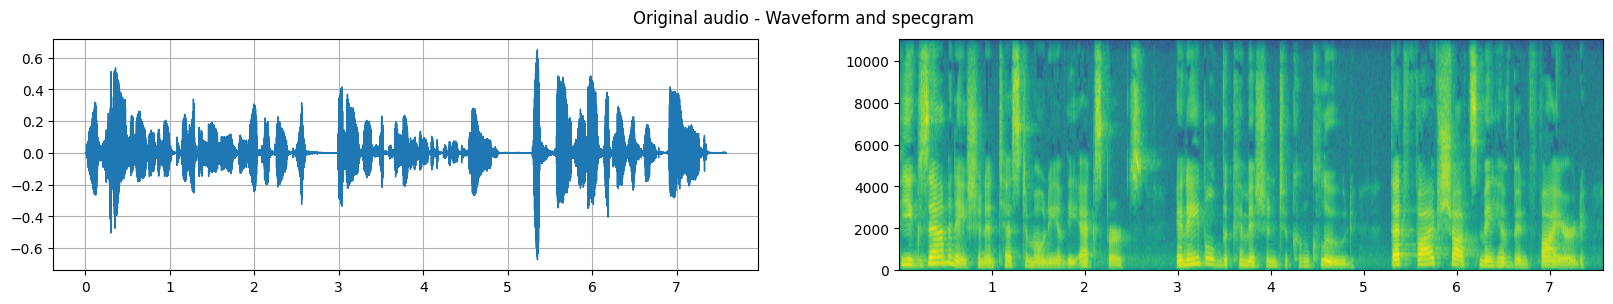

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

from notebook import play_audio, plot_waveform_and_specgram

plot_waveform_and_specgram(audio, sr, title="Original audio")

In [ ]:
play_audio(audio, sr)

## Generator

To watermark an audio, we simply load the watermarking generator from the hub:

In [42]:
from audioseal import AudioSeal

model = AudioSeal.load_generator("audioseal_wm_16bits")
model.eval()

# Optional: move model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()
    audio = audio.cuda()

# We add the batch dimension to the single audio to mimic the batch watermarking
audios = audio.unsqueeze(0)

watermark = model.get_watermark(audios)
alpha = 1.0 # the watermarking strength
watermarked_audio = audios + alpha * watermark

# Alternatively, you can also call forward() function directly with different tune-down / tune-up rate
watermarked_audio = model(audios, alpha=alpha)

We can see that the watermarked audio has preserved almost the same spectrogram and contents as the original one

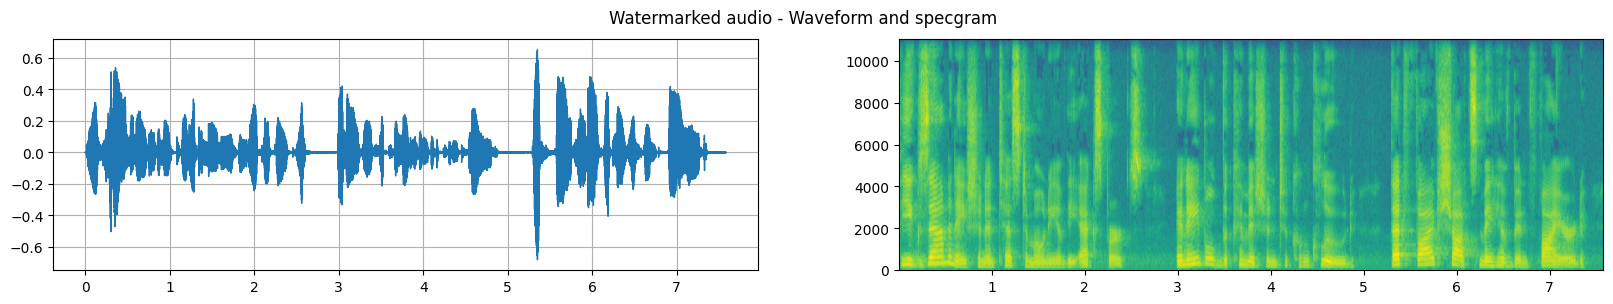

In [6]:
plot_waveform_and_specgram(watermarked_audio.squeeze(), sr, title="Watermarked audio")

In [ ]:
play_audio(watermarked_audio, sr)

### Watermarking with a secret message:

AudioSeal uses a secret message to generate a watermarking, which consists of <i>n</i> binary bits (n=16 for the above model, hence the model name). By default, if the user does not specify these n bits, a random message will be generated. This can be customized either by assigning the secret message before the watermarking process:

```
`model.message = <n bit Tensor>`
``` 

or by executing the model each time with one explicit secret message:

```
watermark = model(audio, message=<message>)
```

In [ ]:
secret_mesage = torch.randint(0, 2, (1, 16), dtype=torch.int32)
secret_mesage

tensor([[0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1]], dtype=torch.int32)

In [9]:
if torch.cuda.is_available():
    secret_mesage = secret_mesage.cuda()

watermarked_audio = model(audios, sample_rate=sr, message=secret_mesage, alpha=1)

Deprecated Warning: `sample_rate` is specified but it will be ignored. 
Consider removing `sample_rate` in the model call as this is a no-op
Starting from AudioSeal 0.2+, audio is not resampled internally to 16kHz or some predefined sample rates. The user is responsible for providing the correct sample rate to the model.



## Detector

To detect the watermarks from an audio, we load the separate detector model and can do one of the following:

### Basic usage: Call `detect_watermark()`
This results in a tuple of form `Tuple(float, Tensor)`, where the first value indicates the probability of the audio being watermarked (the higher, the more likely), and the second value is the decoded message that is embeded by the generator. If the audio is unwatermarked (low first value), the decoded message will be just some random bits.

Note that due to the stochastic nature of the detector, the decoded message and the secret message might miss by 1 bit, so depending on the user's need, the detection might be called multiple times to get an averaged decoded message.

In [10]:
detector = AudioSeal.load_detector(("audioseal_detector_16bits"))
detector.eval()

if torch.cuda.is_available():
    detector = detector.cuda()

result, message = detector.detect_watermark(watermarked_audio, sample_rate=sr, message_threshold=0.5)

print(f"\nThis is likely a watermarked audio: {result}")

# Run on an unwatermarked audio
result2, message2 = detector.detect_watermark(audios, sample_rate=sr, message_threshold=0.5)
print(f"This is likely an unwatermarked audio: {result2}")



This is likely a watermarked audio: tensor([1.], device='cuda:0')
This is likely an unwatermarked audio: tensor([0.0036], device='cuda:0')


In [11]:
message

tensor([[0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1]], device='cuda:0',
       dtype=torch.int32)

`message_threshold` indicates the threshold in which the detector will convert the stochastic messages (with probability between 0 and 1) into the n-bit binary format. In most of the case, the generator generates an unbiased message from the secret, so `0.5` is a reasonable choice (so in the above example, value > 0.5 means 1 and value < 0.5 means 0). 


#### Advanced usage: Call `forward()`

The detector can also be called directly as a Torch module. This will return 2 tensors: 
- The first tensor of size `batch x 2 x frames` indicates the probability of each frame being watermarked (positive or negative). So t[:, 0, :] corresponds to the negative probability and t[:, 1, :] corresponds to the positive probability
- The second tensor of size `batch x n_bits` corresponds to the message detected from the audio. It indicates the probability for each bit to be 1. In case of unwatermarked audios, this tensor is random

In [12]:
pred_prob, message_prob = detector(watermarked_audio, sample_rate=sr)
pred_prob[:, 1, :]

tensor([[0.9999, 0.9999, 0.9999,  ..., 0.9704, 0.9700, 0.9698]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [13]:
message_prob

tensor([[0.2305, 0.2333, 0.2218, 0.7964, 0.7817, 0.2108, 0.1801, 0.2383, 0.3045,
         0.7989, 0.2152, 0.7940, 0.7943, 0.7563, 0.2642, 0.7823]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

### Robustness against attacks

We can evaluate the robustness of the detector against some attacks. For this purpose, we will perform some simple attacks: Pink noise, highpass filter, compression in different formats. For the full list of attacks, please refer to our paper. 


#### Pink noise attack

In [14]:
from attacks import AudioEffects as af

pink_noised_audio = af.pink_noise(watermarked_audio, noise_std=0.2)

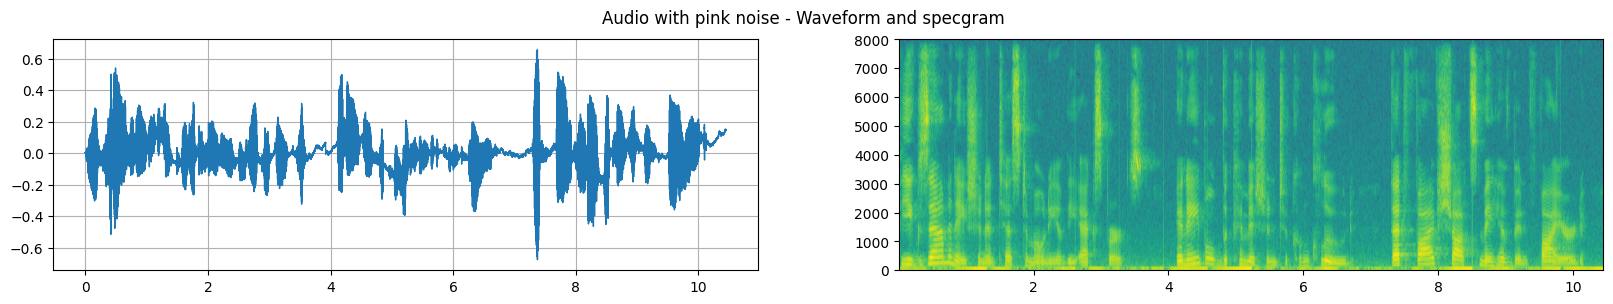

In [15]:
plot_waveform_and_specgram(pink_noised_audio, sample_rate=16000, title="Audio with pink noise")

In [16]:
result, message = detector.detect_watermark(pink_noised_audio)
result

tensor([0.9554], device='cuda:0')

#### Lowpass filter

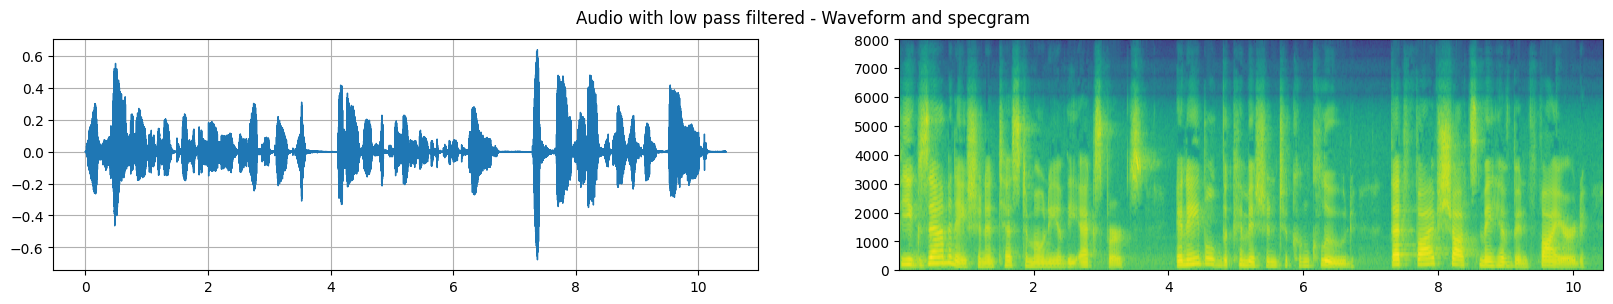

In [17]:
lowpass_filtered = af.lowpass_filter(watermarked_audio, cutoff_freq=5000, sample_rate=16000)
plot_waveform_and_specgram(lowpass_filtered, sample_rate=16000, title="Audio with low pass filtered")

In [18]:
result, message = detector.detect_watermark(lowpass_filtered)
result

tensor([1.], device='cuda:0')

## Streaming Audio Watermarking

To run audioseal in streaming mode, we could turn on the generator cache with `model.streaming(batch_size)`:


In [52]:
streaming_watermarked_audio = []

# Loading a model that supports streaming watermarking, i.e. trained with causal convolutions
model = AudioSeal.load_generator("audioseal_wm_streaming")
model.eval()

if torch.cuda.is_available():
    model = model.cuda()
    audio = audio.cuda()

with model.streaming(batch_size=1):
    
    # Simulate the streaming input by splitting the audio into chunks
    chunk_size = sr * 2  # 2-second chunks
    for start in range(0, audios.size(1), chunk_size):
        end = min(start + chunk_size, audios.size(1))
        chunk = audios[:, start:end]
        watermarked_chunk = model(chunk, sample_rate=sr, message=secret_mesage, alpha=1)
        streaming_watermarked_audio.append(watermarked_chunk)
    
streaming_watermarked_audio = torch.cat(streaming_watermarked_audio, dim=1)

play_audio(streaming_watermarked_audio, sr)

/private/home/tuantran/.conda/envs/aseal/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


The detection can be done on a chunk of audios, or on entire audios. The longer the watermarked audio, the better the accuracy, although AudioSeal can recover the message from a very small number of chunks

In [59]:

def message_accuracy(message: torch.Tensor, gt_message: torch.Tensor) -> float:
    """Calculate the message accuracy between the detected message and the ground truth message."""

    # Bit accuracy: number of matching bits between the key and the message, divided by the total number of bits.
    # p-value: probability of observing a bit accuracy as high as the one observed, assuming the null hypothesis that the image is genuine.
    diff = ~torch.logical_xor(message > 0, gt_message > 0)  # b k -> b k

    bit_accs = torch.sum(diff, dim=-1) / diff.shape[-1]  # b k -> b
    avg_bit_acc = bit_accs.mean()
    return avg_bit_acc.item()


detector = AudioSeal.load_detector(("audioseal_detector_streaming"))
detector.eval()

if torch.cuda.is_available():
    detector = detector.cuda()


for chunk in [100, 1000, 16000, 48000, 64000]:
    result, message = detector.detect_watermark(streaming_watermarked_audio[:, :, :chunk])
    acc = message_accuracy(message, secret_mesage)
    print(f"Chunk size: {chunk} samples - Watermark detected: {result}. Message accuracy: {acc}")



Chunk size: 100 samples - Watermark detected: tensor([0.8700], device='cuda:0'). Message accuracy: 0.625
Chunk size: 1000 samples - Watermark detected: tensor([0.9930], device='cuda:0'). Message accuracy: 1.0
Chunk size: 16000 samples - Watermark detected: tensor([1.], device='cuda:0'). Message accuracy: 1.0
Chunk size: 48000 samples - Watermark detected: tensor([1.], device='cuda:0'). Message accuracy: 1.0
Chunk size: 64000 samples - Watermark detected: tensor([1.], device='cuda:0'). Message accuracy: 1.0
